In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import moose

#### Create container for model and set parameters

In [2]:
r0 = 1e-6	# m
r1 = 0.5e-6	# m. Note taper.
num = 200
diffLength = 1e-6 # m
comptLength = num * diffLength	# m
diffConst = 20e-12 # m^2/sec

diffDt = 0.02  # for the diffusion
chemDt = 0.2   # for the reaction

model = moose.Neutral( 'model' )
compartment = moose.CylMesh( '/model/kinetics' )

concA = 1 # millimolar
mfile = 'M1719.g'
method = 'ee'

#### Load in model and setup kinetics and diffusion

In [3]:
modelId = moose.loadModel( mfile, '/model', method )
b = moose.element( '/model/kinetics/b' )

compartment.r0 = r0
compartment.r1 = r1
compartment.x0 = 0
compartment.x1 = comptLength
compartment.diffLength = diffLength
assert( compartment.numDiffCompts == num )

# Assign parameters
for x in moose.wildcardFind( '/model/kinetics/##[ISA=PoolBase]' ):
    #print 'pools: ', x, x.name
    x.diffConst = diffConst

In [4]:
# Make solvers
ksolve = moose.Ksolve( '/model/kinetics/ksolve' )
dsolve = moose.Dsolve( '/model/dsolve' )

# Set up clocks.
moose.setClock( 10, diffDt )
for i in range( 11, 17 ):
    moose.setClock( i, chemDt )

stoich = moose.Stoich( '/model/kinetics/stoich' )
stoich.compartment = compartment
stoich.ksolve = ksolve
stoich.dsolve = dsolve
stoich.path = "/model/kinetics/##"

In [5]:
b.vec[num-1].concInit *= 1.01 # Break symmetry.

Swapping concs of b and c in half the cylinder
200


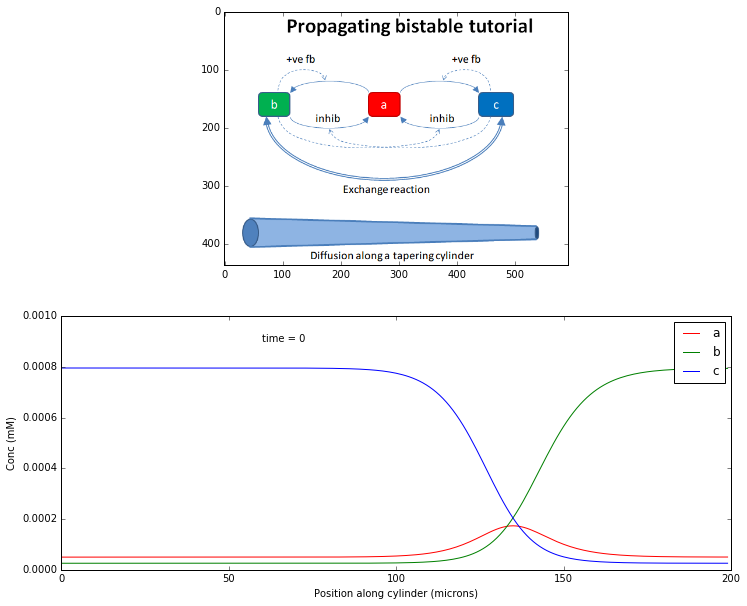

In [6]:
runtime = 1000

dsolve = moose.element( '/model/dsolve' )
moose.reinit()

a = moose.element( '/model/kinetics/a' )
b = moose.element( '/model/kinetics/b' )
c = moose.element( '/model/kinetics/c' )

img = mpimg.imread( 'propBis.png' )

fig = plt.figure( figsize=(12,10) )
png = fig.add_subplot(211)
imgplot = plt.imshow( img )
ax = fig.add_subplot(212)
ax.set_ylim( 0, 0.001 )
plt.ylabel( 'Conc (mM)' )
plt.xlabel( 'Position along cylinder (microns)' )
pos = numpy.arange( 0, a.vec.conc.size, 1 )
line1, = ax.plot( pos, a.vec.conc, 'r-', label='a' )
line2, = ax.plot( pos, b.vec.conc, 'g-',  label='b' )
line3, = ax.plot( pos, c.vec.conc, 'b-', label='c' )
timeLabel = plt.text(60, 0.0009, 'time = 0')
plt.legend()
fig.canvas.draw()

moose.start( runtime )
line1.set_ydata( a.vec.conc )
line2.set_ydata( b.vec.conc )
line3.set_ydata( c.vec.conc )

print 'Swapping concs of b and c in half the cylinder'

print b.numData
for i in range( b.numData/2 ):
    temp = b.vec[i].conc
    b.vec[i].conc = c.vec[i].conc
    c.vec[i].conc = temp

newruntime = 200

moose.start( newruntime )
line1.set_ydata( a.vec.conc )
line2.set_ydata( b.vec.conc )
line3.set_ydata( c.vec.conc )